# **Visualisations**

This section presents key visual insights and predictive modelling outputs supporting the analysis of climate tipping points. A range of charts—including bar charts, line graphs, scatterplots, boxplots, regression plots, and an interactive map—were created using Plotly, Matplotlib, and Seaborn.

To further explore underlying trends, scikit-learn was used to build predictive models, enabling analysis of the relationships between renewable energy adoption, energy intensity, and CO₂ emissions per capita. These tools help identify patterns, outliers, and potential thresholds essential to understanding global decarbonisation dynamics.

<br>

*Disclaimer: Some of the code snippets in this project were created or refined with the assistance of ChatGPT to support learning and exploration.*

In [1]:
# import libraries
import numpy as np
import pandas as pd 
import seaborn as sns 
import plotly.express as px 
import matplotlib.pyplot as plt 
import statsmodels.api as sm
import scipy.stats as stats

# load data
df = pd.read_csv('../data/cleaned/enhanced_energy_features.csv')
df.head()

,country,year,elec_access_pct,clean_fuels_access_pct,renew_cap_kw_pc,climate_finance_usd,renewables_share_pct,fossil_elec_twh,nuclear_elec_twh,renew_elec_twh,...,region_miss,subregion_miss,co2_per_capita_t,log_co2_per_capita_t,log_renewables_share_pct,log_energy_intensity_mj_usd,log_gdp_pc_usd,above_30_pct,year_offset,renewables_3yr_avg
0,Afghanistan,2000,1.613591,6.2,9.22,20000.0,44.99,0.16,0.0,0.31,...,0,0,0.037754,0.037059,3.828424,0.970779,5.195324,1,0,44.990000
1,Afghanistan,2001,4.074574,7.2,8.86,130000.0,45.60,0.09,0.0,0.50,...,0,0,0.035988,0.035356,3.841601,1.007958,5.195324,1,1,45.295000
2,Afghanistan,2002,9.409158,8.2,8.47,3950000.0,37.83,0.13,0.0,0.56,...,0,0,0.048180,0.047055,3.659193,0.875469,5.195324,1,2,42.806667
3,Afghanistan,2003,14.738506,9.5,8.09,25970000.0,36.66,0.31,0.0,0.63,...,0,0,0.053666,0.052276,3.628599,0.875469,5.255847,1,3,40.030000
4,Afghanistan,2004,20.064968,10.9,7.75,0.0,44.24,0.33,0.0,0.56,...,0,0,0.043717,0.042788,3.811982,0.788457,5.358387,1,4,39.576667


In [51]:
# Group countries by region and subregion

import pandas as pd

# Load & clean
df = (
    pd.read_csv("../data/cleaned/enhanced_energy_features_final.csv")
      .loc[:, ['region', 'subregion', 'country']]
      .dropna()
      .drop_duplicates()
)

# Group & join countries
grouped = (
    df
    .groupby(['region', 'subregion'])['country']
    .apply(lambda lst: ", ".join(sorted(lst)))
    .reset_index(name="Countries")
)

# Compute column widths
cols = ['Region', 'Subregion', 'Countries']
widths = [
    max(grouped['region'].map(len).max(), len(cols[0])),
    max(grouped['subregion'].map(len).max(), len(cols[1])),
    max(grouped['Countries'].map(len).max(), len(cols[2])),
]

# Prepare formats
header_fmt = f"{{:<{widths[0]}}} | {{:<{widths[1]}}} | {{:<{widths[2]}}}"
separator  = f"{'-'*widths[0]}-+-{'-'*widths[1]}-+-{'-'*widths[2]}"
row_fmt    = header_fmt

# Print table
print(header_fmt.format(*cols))
print(separator)
for _, row in grouped.iterrows():
    print(row_fmt.format(row['region'], row['subregion'], row['Countries']))


Region   | Subregion                       | Countries                                                                                                                                                                                                                                                                                                                                                                                                                                                           
---------+---------------------------------+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Afri

In [ ]:
# Energy Mix Transition by Subregion (Sankey Plot) - interactive visual

import pandas as pd
import plotly.graph_objects as go

# Load data
df = pd.read_csv('../data/cleaned/enhanced_energy_features_final.csv')  

# Step 1: Aggregate average renewables share by subregion
df_subregion = df[['subregion', 'renewables_share_pct']].dropna()
avg_renew = df_subregion.groupby('subregion')['renewables_share_pct'].mean().reset_index()

# Step 2: Categorise by level of renewable energy share
def categorize(share):
    if share >= 50:
        return 'High Renewables'
    elif share >= 30:
        return 'Moderate Renewables'
    else:
        return 'Low Renewables'

avg_renew['category'] = avg_renew['renewables_share_pct'].apply(categorize)

# Step 3: Prepare for Sankey
sankey_df = avg_renew[['subregion', 'category']]
sankey_df['count'] = 1

labels = list(sankey_df['subregion'].unique()) + list(sankey_df['category'].unique())
label_to_index = {label: i for i, label in enumerate(labels)}

sources = sankey_df['subregion'].map(label_to_index).tolist()
targets = sankey_df['category'].map(label_to_index).tolist()
values = sankey_df['count'].tolist()

# Step 4: Sankey Diagram
fig = go.Figure(data=[go.Sankey(
    node=dict(
        pad=20,
        thickness=20,
        line=dict(color="black", width=0.5),
        label=labels,
        color="lightgreen"
    ),
    link=dict(
        source=sources,
        target=targets,
        value=values,
        color="rgba(0, 128, 0, 0.3)"
    )
)])

fig.update_layout(
    title_text="Energy Mix Transition by Subregion (2000 - 2020)",
    font=dict(size=14, color="black", family="Arial"),
    margin=dict(l=100, r=100, t=50, b=50)
)

fig.show()

In [ ]:
# Energy Mix Transition by Region (Sankey Plot) - interactive visual

import pandas as pd
import plotly.graph_objects as go

# Load your data
df = pd.read_csv("../data/cleaned/enhanced_energy_features.csv") 

# Categorization logic
def categorize(share):
    if share >= 50:
        return 'High Renewables'
    elif share >= 30:
        return 'Moderate Renewables'
    else:
        return 'Low Renewables'

# Average renewables by region
df_region = df[['region', 'renewables_share_pct']].dropna()
avg_renew = df_region.groupby('region')['renewables_share_pct'].mean().reset_index()
avg_renew['category'] = avg_renew['renewables_share_pct'].apply(categorize)

# Sankey structure
sankey_df = avg_renew[['region', 'category']]
sankey_df['count'] = 1

labels = list(sankey_df['region'].unique()) + list(sankey_df['category'].unique())
label_map = {label: i for i, label in enumerate(labels)}

sources = sankey_df['region'].map(label_map).tolist()
targets = sankey_df['category'].map(label_map).tolist()
values = sankey_df['count'].tolist()

# Sankey chart
fig = go.Figure(data=[go.Sankey(
    node=dict(
        pad=20,
        thickness=20,
        line=dict(color="black", width=0.5),
        label=labels,
        color="lightblue"
    ),
    link=dict(
        source=sources,
        target=targets,
        value=values,
        color="rgba(0, 100, 200, 0.3)"
    )
)])

fig.update_layout(
    title_text="Energy Mix Transition by Region (2000 - 2020)",
    font=dict(size=14, color="black", family="Arial"),
    margin=dict(l=100, r=100, t=50, b=50)
)

fig.show()


<Figure size 1200x600 with 0 Axes>

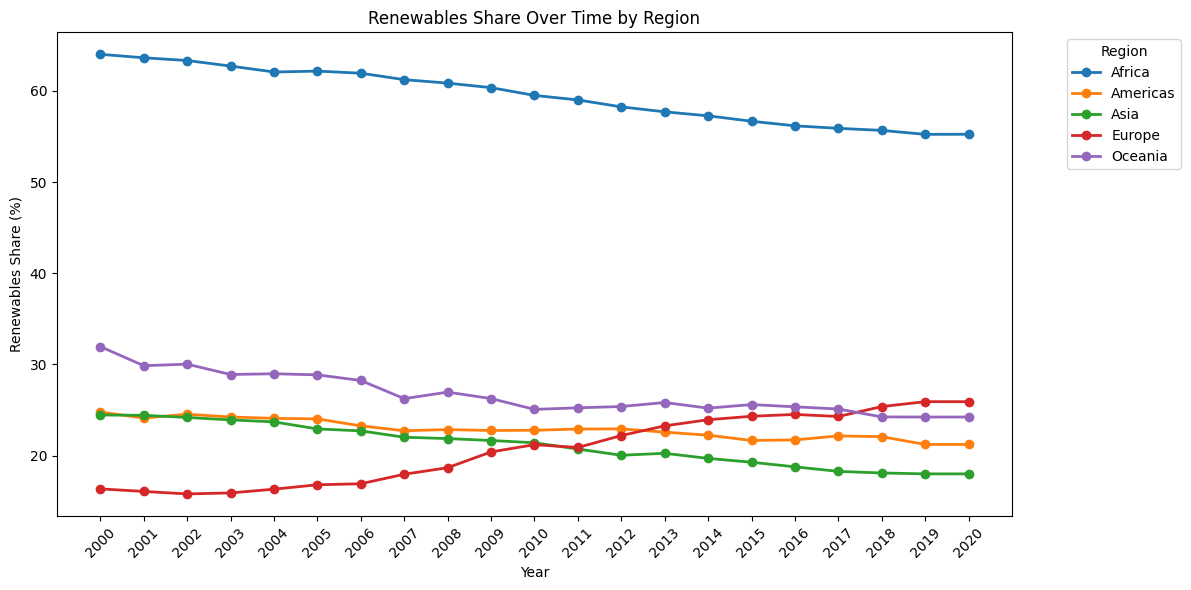

In [ ]:
# Create line chart — renewables share over time by region - static visual

import pandas as pd
import matplotlib.pyplot as plt

# Step 1: Load data
df = pd.read_csv("../data/cleaned/enhanced_energy_features_final.csv")  

# Step 2: Filter relevant columns and drop NaNs
df_filtered = df[['year', 'region', 'renewables_share_pct']].dropna()

# Ensure year is integer for plotting
df_filtered['year'] = df_filtered['year'].astype(int)

# Step 3: Calculate average renewables share by region per year
df_line = (
    df_filtered
    .groupby(['year', 'region'])['renewables_share_pct']
    .mean()
    .reset_index()
    .pivot(index='year', columns='region', values='renewables_share_pct')
)

# Step 4: Plot line chart
plt.figure(figsize=(12, 6))
df_line.plot(kind='line', marker='o', linewidth=2, figsize=(12, 6))
plt.title('Renewables Share Over Time by Region')
plt.ylabel('Renewables Share (%)')
plt.xlabel('Year')

# Force x-axis ticks to be integers
plt.xticks(df_line.index, df_line.index.astype(int), rotation=45)

# Add legend and grid
plt.legend(title='Region', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(False)
plt.tight_layout()
plt.show()


In [ ]:
# Create a plotly line chart — renewables share over time by subregion - interactive visual

import pandas as pd
import plotly.express as px

# Load data
df = pd.read_csv("../data/cleaned/enhanced_energy_features.csv")
df_filtered = df[['year', 'subregion', 'renewables_share_pct']].dropna()
df_filtered['year'] = df_filtered['year'].astype(int)

# Group by year and subregion
df_grouped = (
    df_filtered
    .groupby(['year', 'subregion'])['renewables_share_pct']
    .mean()
    .reset_index()
)

# Plotly line chart
fig = px.line(
    df_grouped,
    x='year',
    y='renewables_share_pct',
    color='subregion',
    title='Renewables Share Over Time by Subregion',
    labels={
        'year': 'Year',
        'renewables_share_pct': 'Renewables Share (%)',
        'subregion': 'Subregion'
    },
    markers=False
)

# Update layout: rotate x-axis ticks and move legend to bottom
fig.update_layout(
    xaxis=dict(
        tickmode='linear',
        tickangle=45
    ),
    legend_title='Subregion',
    height=600,
    legend=dict(
        orientation="h",
        yanchor="top",
        y=-0.3,         # Adjust if needed
        xanchor="center",
        x=0.5
    )
)

fig.show()


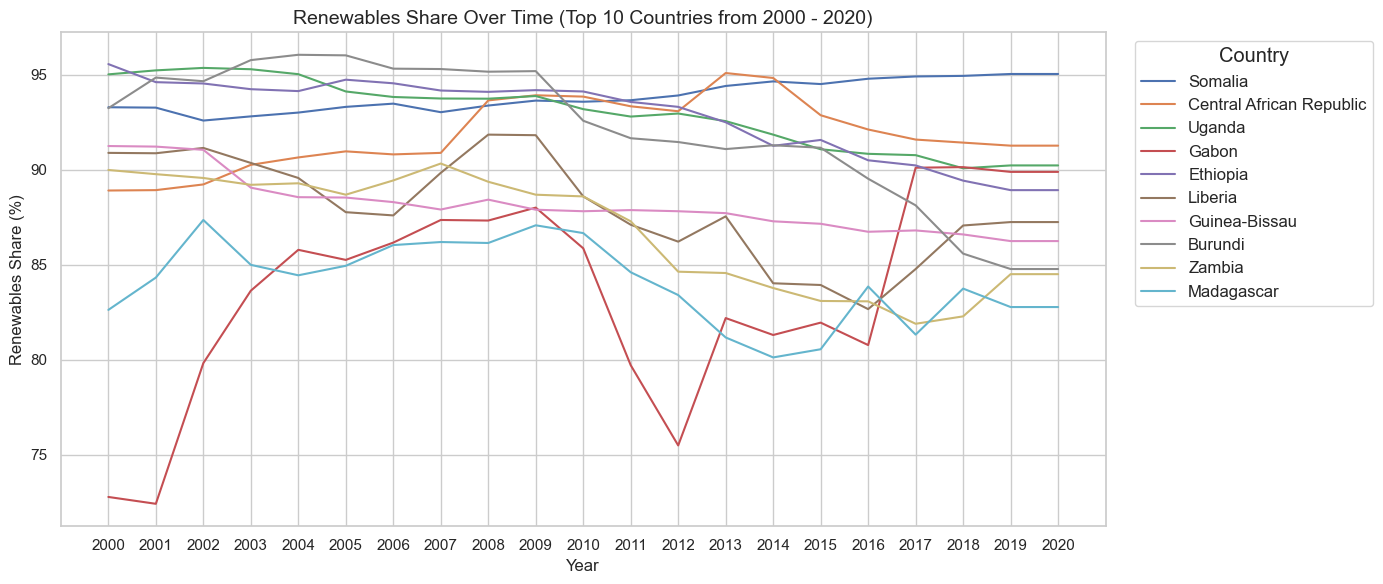

In [ ]:
# Top 10 Countries by Renewables Share (%) - static visual

import pandas as pd
import matplotlib.pyplot as plt

# Load dataset
df = pd.read_csv('../data/cleaned/enhanced_energy_features_final.csv')

# Drop rows with missing values in target column
df = df.dropna(subset=['renewables_share_pct'])

# Make sure 'year' is integer
df['year'] = df['year'].astype(int)

# Get top 10 countries in 2020 by renewables share
df_2020 = df[df['year'] == 2020]
top10 = df_2020.nlargest(10, 'renewables_share_pct')['country'].tolist()

# Filter data for those countries
df_top10 = df[df['country'].isin(top10)]

# Plot
plt.figure(figsize=(14, 6))

for country in sorted(top10, key=lambda c: df_2020[df_2020['country'] == c]['renewables_share_pct'].values[0], reverse=True):
    df_country = df_top10[df_top10['country'] == country]
    plt.plot(df_country['year'], df_country['renewables_share_pct'], label=country)

# Force x-axis to show every year from 2000 to 2020 as integer
plt.xticks(ticks=list(range(2000, 2021)))
plt.gca().xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{int(x)}'))

# Titles and labels
plt.title('Renewables Share Over Time (Top 10 Countries from 2000 - 2020)', fontsize=14)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Renewables Share (%)', fontsize=12)

# Increase legend size
plt.legend(title='Country', bbox_to_anchor=(1.02, 1), loc='upper left', fontsize='medium', title_fontsize='large')

plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
# Top10 countries by renewables shares (%) over time - interative visual

import pandas as pd
import plotly.express as px

# Load  dataset
df = pd.read_csv("../data/cleaned/enhanced_energy_features_final.csv")

# Ensure year is an integer
df['year'] = df['year'].astype(int)

# Step 1: Get top 10 countries by renewables share in 2020
top10_countries = (
    df[df['year'] == 2020]
    .nlargest(10, 'renewables_share_pct')
    .sort_values('renewables_share_pct', ascending=False)
)['country'].tolist()

# Step 2: Filter dataset and avoid SettingWithCopyWarning
df_top10 = df[df['country'].isin(top10_countries)].copy()

# Reset index (help in avoiding some warnings)
df_top10.reset_index(drop=True, inplace=True)

# Explicitly set country order using .loc to avoid warning
df_top10.loc[:, 'country'] = pd.Categorical(
    df_top10['country'],
    categories=top10_countries,
    ordered=True
)

# Step 3: Create line chart with legend ordered
fig = px.line(
    df_top10,
    x='year',
    y='renewables_share_pct',
    color='country',
    title='Top 10 Countries by Renewables Share (%) Over Time',
    labels={
        'renewables_share_pct': 'Renewables Share (%)',
        'year': 'Year'
    },
    category_orders={'country': top10_countries},  # ensure proper legend order
)

# Step 4: Format chart layout
fig.update_layout(
    legend_title_text='Country',
    legend_traceorder='normal',
    legend=dict(
        font=dict(size=12),
        yanchor="top",
        y=1,
        xanchor="left",
        x=1.01
    ),
    xaxis=dict(tickmode='linear', tick0=2000, dtick=2),
)

fig.show()


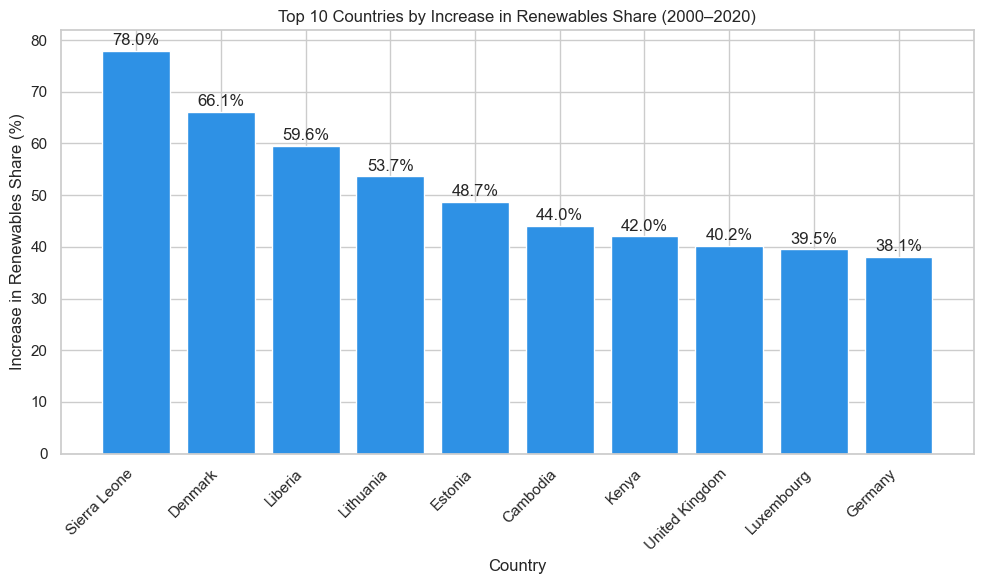

year         country  renew_2000  renew_2020     change
0       Sierra Leone   12.500000   90.476190  77.976190
1            Denmark   15.472222   81.621998  66.149776
2            Liberia    0.000000   59.550562  59.550562
3          Lithuania    3.082502   56.732892  53.650390
4            Estonia    0.117509   48.848684  48.731175
5           Cambodia   10.638298   54.674556  44.036258
6              Kenya   50.123457   92.170213  42.046756
7     United Kingdom    2.665741   42.860396  40.194656
8         Luxembourg   40.000000   79.508197  39.508197
9            Germany    6.197798   44.332405  38.134607


In [ ]:
# Analyse Renewables share change at country level - static visual

import pandas as pd
import matplotlib.pyplot as plt

# Load dataset
df = pd.read_csv('../data/cleaned/enhanced_energy_features_final.csv')

# Ensure correct dtypes
df['year'] = df['year'].astype(int)

# Handle missing values in electricity columns
electricity_cols = ['fossil_elec_twh', 'nuclear_elec_twh', 'renew_elec_twh']
df[electricity_cols] = df[electricity_cols].fillna(0)

# Aggregate by country and year
country_agg = df.groupby(['country', 'year'])[electricity_cols].sum().reset_index()

# Calculate total electricity generation (including nuclear)
country_agg['total'] = country_agg[electricity_cols].sum(axis=1)

# Remove rows where total is zero (to avoid division errors)
country_agg = country_agg[country_agg['total'] > 0]

# Calculate renewables share as percentage of total
country_agg['renew_pct'] = (country_agg['renew_elec_twh'] / country_agg['total']) * 100

# Pivot to get 2000 vs 2020
country_pivot = country_agg.pivot(index='country', columns='year', values='renew_pct')

# Ensure both years are present
if 2000 in country_pivot.columns and 2020 in country_pivot.columns:
    country_change = country_pivot[[2000, 2020]].dropna().rename(
        columns={2000: 'renew_2000', 2020: 'renew_2020'}
    )
    country_change['change'] = country_change['renew_2020'] - country_change['renew_2000']

    # Top 10 countries by increase
    top10 = country_change.sort_values('change', ascending=False).head(10).reset_index()

    # Bar chart of top 10 gains
    plt.figure(figsize=(10, 6))
    bar_color = '#2E91E5'
    plt.bar(top10['country'], top10['change'], color=bar_color)
    plt.xlabel('Country')
    plt.ylabel('Increase in Renewables Share (%)')
    plt.title('Top 10 Countries by Increase in Renewables Share (2000–2020)')
    plt.xticks(rotation=45, ha='right')

    # Optional: Add data labels
    for i, val in enumerate(top10['change']):
        plt.text(i, val + 0.5, f"{val:.1f}%", ha='center', va='bottom')

    plt.tight_layout()
    plt.show()

    # Optional: Print summary table
    print(top10[['country', 'renew_2000', 'renew_2020', 'change']])
else:
    raise ValueError("Data for years 2000 and/or 2020 is missing.")


#### Interpretation: Top 10 Countries by Increase in Renewables Share (2000–2020)

This bar chart illustrates the ten countries that achieved the greatest increase in the share of electricity generated from renewable sources between 2000 and 2020. The percentage represents the change in renewables as a share of total electricity generation (including fossil, nuclear, and renewables).

##### Key Insights:

- **Sierra Leone** leads the list with a remarkable **+78.0%** increase, likely due to expanded hydropower and shifts away from fossil fuels.
- **Denmark** shows a significant **+66.1%** gain, aligning with its long-term investment in wind energy and strong national climate policies.
- **Liberia, Cambodia, and Kenya**, among other developing nations, demonstrate substantial progress—possibly reflecting greenfield investments or hydropower expansion during infrastructure development.
- **Germany** and the **United Kingdom**, both industrialised economies, appear in the top 10, underlining the impact of major policy-led energy transitions.
- **Lithuania and Estonia**, post-Soviet states, also show strong gains, likely driven by EU energy targets and diversification efforts.

 **Note**: This chart shows the *change over time*, not the absolute share of renewables in 2020. Some countries may have started from a low baseline in 2000, so while their improvement is notable, it doesn't necessarily indicate a high final share.



In [ ]:
# Top 15 Countries CO₂ Drop After 30% Renewables  - interactive visual

import pandas as pd
import plotly.express as px

# Load data
df = pd.read_csv("../data/cleaned/enhanced_energy_features_final.csv")
df['year'] = df['year'].astype(int)
df['above_30_pct'] = df['renewables_share_pct'] >= 30

# Step 1: Average CO₂ before and after tipping point
df_avg = (
    df.dropna(subset=['co2_per_capita_t', 'renewables_share_pct'])
      .groupby(['country', 'above_30_pct'], observed=True)['co2_per_capita_t']
      .mean()
      .reset_index()
)

# Step 2: Pivot to wide format
df_wide = df_avg.pivot(index='country', columns='above_30_pct', values='co2_per_capita_t').reset_index()
df_wide.columns = ['country', 'co2_before_30', 'co2_after_30']

# Step 3: Drop countries with missing values in either group
df_wide = df_wide.dropna(subset=['co2_before_30', 'co2_after_30'])

# Step 4: Calculate CO₂ change
df_wide['co2_change'] = df_wide['co2_after_30'] - df_wide['co2_before_30']

# Step 5: Get top 15 countries with largest CO₂ reduction (negative values)
top_reducers = df_wide.sort_values(by='co2_change').head(15)

# Step 6: Melt for grouped bar chart
df_melted = pd.melt(
    top_reducers,
    id_vars='country',
    value_vars=['co2_before_30', 'co2_after_30'],
    var_name='Threshold',
    value_name='Avg CO₂ per Capita'
)

# Step 7: Clean label
df_melted['Threshold'] = df_melted['Threshold'].map({
    'co2_before_30': 'Before 30%',
    'co2_after_30': 'After ≥30%'
})

# Step 8: Plot with Plotly
fig = px.bar(
    df_melted,
    x='country',
    y='Avg CO₂ per Capita',
    color='Threshold',
    barmode='group',
    title='Top 15 Countries: CO₂ Drop After Crossing 30% Renewables Threshold',
    labels={'country': 'Country'},
    category_orders={'Threshold': ['Before 30%', 'After ≥30%']}
)

fig.update_layout(
    xaxis_tickangle=45,
    legend_title_text='Tipping Point Status',
    yaxis_title='Average CO₂ per Capita (tonnes)',
    xaxis_title='',
    legend=dict(
        orientation='h',
        y=1.1,
        x=0.5,
        xanchor='center',
        yanchor='bottom'
    )
)

fig.show()


In [ ]:
# Visualising CO₂ Change by Subregion - interactive visual

import pandas as pd
import plotly.express as px

# Load data
df = pd.read_csv("../data/cleaned/enhanced_energy_features_final.csv")
df['year'] = df['year'].astype(int)
df['above_30_pct'] = df['renewables_share_pct'] >= 30

# Step 1: Group by subregion and tipping point status
df_avg_subregion = (
    df.dropna(subset=['co2_per_capita_t', 'renewables_share_pct', 'subregion'])
      .groupby(['subregion', 'above_30_pct'], observed=True)['co2_per_capita_t']
      .mean()
      .reset_index()
)

# Step 2: Pivot and calculate change
df_wide_sub = df_avg_subregion.pivot(index='subregion', columns='above_30_pct', values='co2_per_capita_t').reset_index()
df_wide_sub.columns = ['subregion', 'co2_before_30', 'co2_after_30']
df_wide_sub = df_wide_sub.dropna()
df_wide_sub['co2_change'] = df_wide_sub['co2_after_30'] - df_wide_sub['co2_before_30']

# Sort before melting
df_wide_sub_sorted = df_wide_sub.sort_values(by='co2_change')

# Step 3: Melt for grouped bar chart
df_melted_sub = pd.melt(
    df_wide_sub_sorted,
    id_vars='subregion',
    value_vars=['co2_before_30', 'co2_after_30'],
    var_name='Threshold',
    value_name='Avg CO₂ per Capita'
)
df_melted_sub['Threshold'] = df_melted_sub['Threshold'].map({
    'co2_before_30': 'Before 30%',
    'co2_after_30': 'After ≥30%'
})

# Step 4: Plot
fig = px.bar(
    df_melted_sub,
    x='subregion',
    y='Avg CO₂ per Capita',
    color='Threshold',
    barmode='group',
    title='Subregion: CO₂ Drop After Crossing 30% Renewables Threshold',
    labels={'subregion': 'Subregion'},
    category_orders={'Threshold': ['Before 30%', 'After ≥30%']}
)

fig.update_layout(
    xaxis_tickangle=30,
    legend_title_text='Tipping Point Status',
    yaxis_title='Average CO₂ per Capita (tonnes)',
    xaxis_title='',
    legend=dict(
        orientation='h',
        y=1.1,
        x=0.5,
        xanchor='center',
        yanchor='bottom'
    )
)

fig.show()



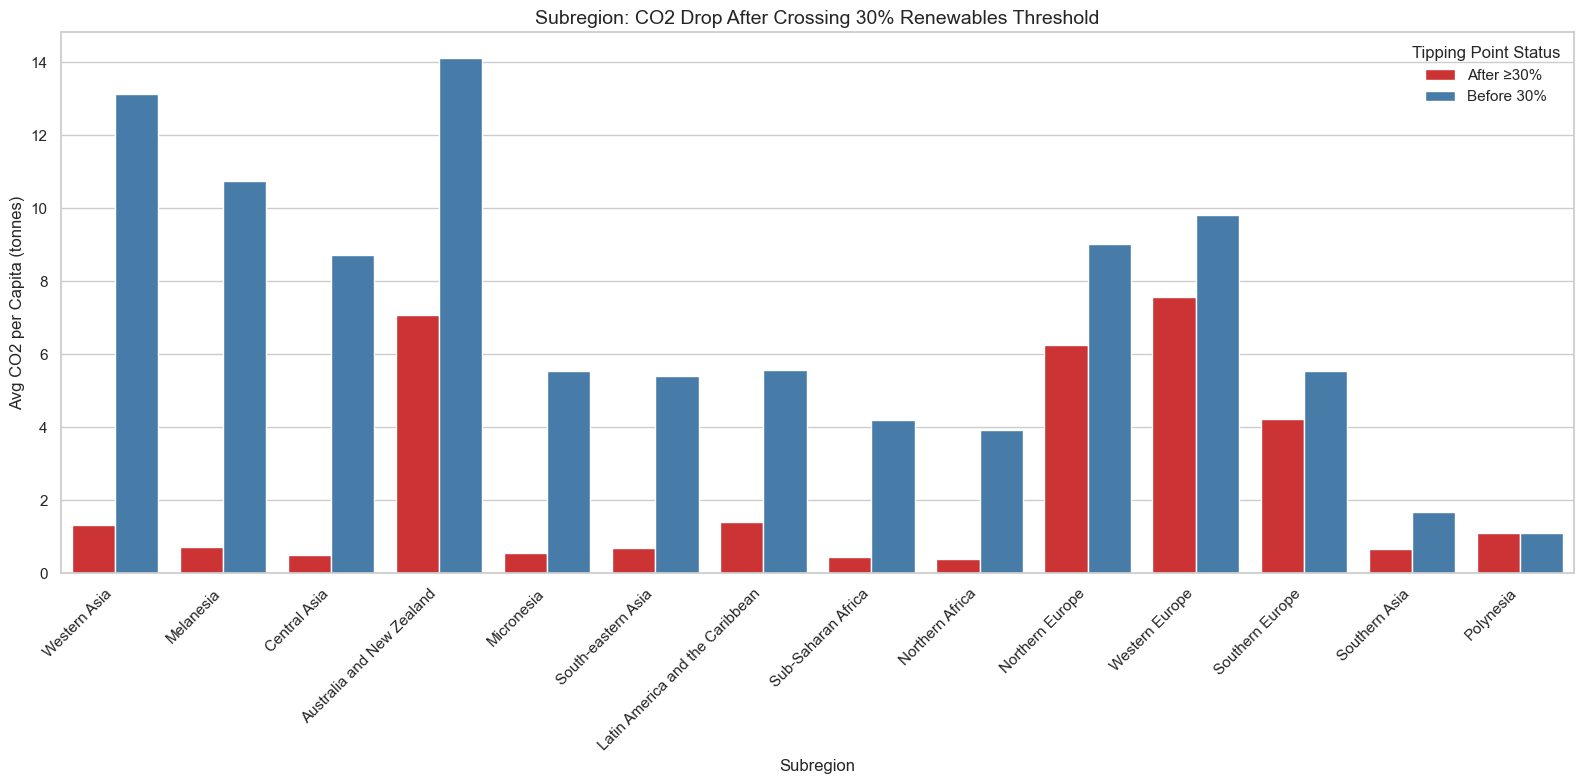

In [ ]:
# Visualising CO₂ Change by Subregion - static visual

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load dataset
df = pd.read_csv("../data/cleaned/enhanced_energy_features_final.csv")

# Filter and prepare data
df_subregion = df.dropna(subset=['subregion', 'co2_per_capita_t']).copy()
df_subregion['Tipping Point Status'] = df_subregion['renewables_share_pct'].apply(
    lambda x: 'After ≥30%' if x >= 30 else 'Before 30%'
)

# Group by subregion and tipping point to calculate average CO2
avg_co2_subregion = (
    df_subregion.groupby(['subregion', 'Tipping Point Status'])['co2_per_capita_t']
    .mean()
    .reset_index()
    .rename(columns={'co2_per_capita_t': 'Avg CO2 per Capita (tonnes)'})
)

# Pivot to calculate CO2 drop (After - Before)
df_pivot = avg_co2_subregion.pivot(index='subregion', columns='Tipping Point Status', values='Avg CO2 per Capita (tonnes)')
df_pivot = df_pivot.dropna(subset=['Before 30%', 'After ≥30%'])  # Remove incomplete subregions
df_pivot['CO2 Change'] = df_pivot['After ≥30%'] - df_pivot['Before 30%']

# Sort subregions by CO2 change
subregion_order = df_pivot.sort_values(by='CO2 Change')['Before 30%'].index.tolist()

# Plot settings
plt.figure(figsize=(16, 8))
sns.set(style='whitegrid')

barplot = sns.barplot(
    data=avg_co2_subregion,
    x='subregion',
    y='Avg CO2 per Capita (tonnes)',
    hue='Tipping Point Status',
    order=subregion_order,
    palette='Set1'
)

# Titles and labels
plt.title("Subregion: CO2 Drop After Crossing 30% Renewables Threshold", fontsize=14)
plt.xlabel("Subregion")
plt.ylabel("Avg CO2 per Capita (tonnes)")
plt.xticks(rotation=45, ha='right')

# Move legend to top-right
plt.legend(
    title="Tipping Point Status",
    loc="upper right",
    bbox_to_anchor=(1.0, 1.0),
    frameon=False
)

plt.tight_layout()
plt.show()


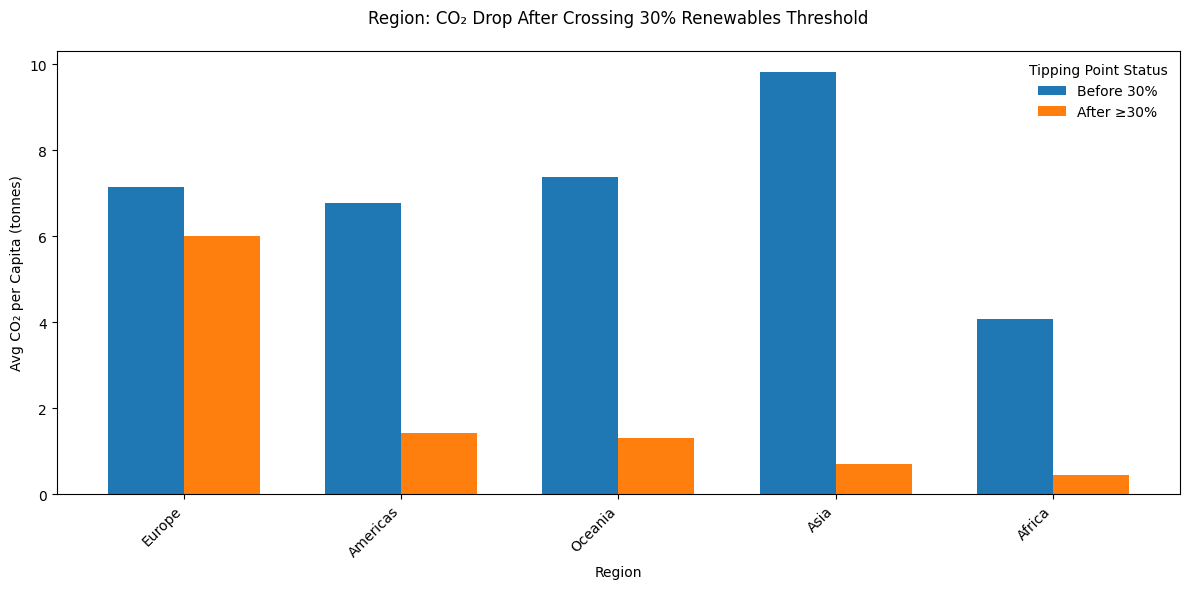

In [ ]:
# Analyse CO₂ Drop After 30% Renewables Threshold by Region - static visual

import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

# Load data
df = pd.read_csv("../data/cleaned/enhanced_energy_features_final.csv")

# Flag for 30% renewables tipping point
df['above_30_pct'] = df['renewables_share_pct'] >= 30

# Group by region and tipping point
df_avg = df.groupby(['region', 'above_30_pct'])['co2_per_capita_t'].mean().reset_index()
df_avg['Threshold'] = df_avg['above_30_pct'].map({True: 'After ≥30%', False: 'Before 30%'})

# Pivot data to wide format
pivot_df = df_avg.pivot(index='region', columns='Threshold', values='co2_per_capita_t')
pivot_df = pivot_df.sort_values(by='After ≥30%', ascending=False)

# Plot setup
fig, ax = plt.subplots(figsize=(12, 6))
bar_width = 0.35
index = range(len(pivot_df))

# Colors
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
color_before = colors[0]
color_after = colors[1]

# Bar charts
ax.bar(index, pivot_df['Before 30%'], bar_width, label='Before 30%', color=color_before)
ax.bar([i + bar_width for i in index], pivot_df['After ≥30%'], bar_width, label='After ≥30%', color=color_after)

# X-axis setup
ax.set_xlabel('Region')
ax.set_ylabel('Avg CO₂ per Capita (tonnes)')
ax.set_xticks([i + bar_width / 2 for i in index])
ax.set_xticklabels(pivot_df.index, rotation=45, ha='right')

# Title above chart only (no overlap)
ax.set_title('Region: CO₂ Drop After Crossing 30% Renewables Threshold', pad=20)

# Legend inside the plot, inline with bars
legend_elements = [
    Patch(facecolor=color_before, label='Before 30%'),
    Patch(facecolor=color_after, label='After ≥30%')
]
ax.legend(
    handles=legend_elements,
    title='Tipping Point Status',
    loc='upper right',
    bbox_to_anchor=(1, 1),
    frameon=False
)

# Improve layout
plt.tight_layout()
plt.show()


Unweighted: β_interaction = -1.2679 (95% CI -1.7975, -0.7382), p=2.71e-06
Weighted (pop): β_interaction = 1.5746 (95% CI 0.9727, 2.1766), p=2.95e-07


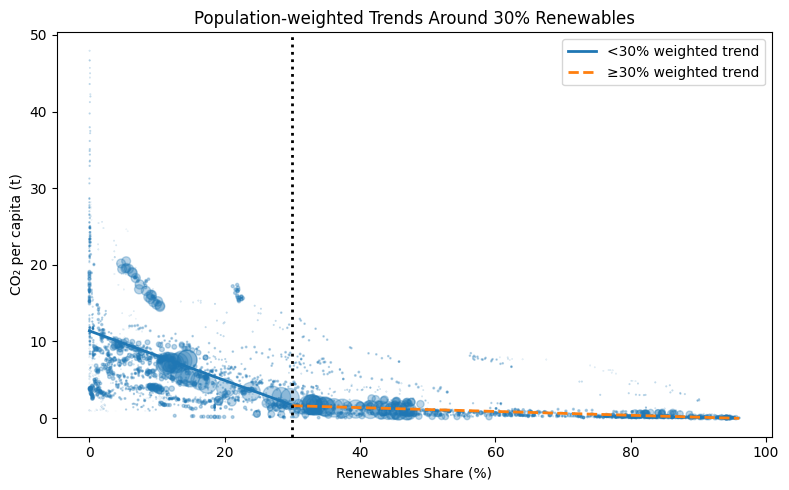

In [ ]:
# Further explore the 30% tipping point threshold using population-weighted data

# ===================== 1. Prep =====================
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import statsmodels.api as sm

df= pd.read_csv('../data/cleaned/enhanced_energy_features_final.csv')

# Keep needed vars & drop NA
cols_needed = ['country','year','renewables_share_pct','co2_per_capita_t',
               'population','energy_intensity_mj_usd']
df_mod = df[cols_needed].dropna()

# Scale renew share to 0–1
df_mod['renew_share'] = df_mod['renewables_share_pct'] / 100

# Tipping dummy (already have above_30_pct but recompute here for clarity)
df_mod['post30'] = (df_mod['renew_share'] >= 0.30).astype(int)

# Logs for % interpretation 
df_mod['ln_co2_pc'] = np.log(df_mod['co2_per_capita_t'])
df_mod['ln_energy_intensity'] = np.log(df_mod['energy_intensity_mj_usd'])

# make sure no zero/neg pop
df_mod = df_mod[df_mod['population'] > 0]


# ===================== 2. Models =====================
formula = "ln_co2_pc ~ renew_share + post30 + post30:renew_share + ln_energy_intensity"

# Unweighted OLS
m_unw = smf.ols(formula, data=df_mod).fit(cov_type='HC3')

# Population-weighted WLS
m_w   = smf.wls(formula, data=df_mod, weights=df_mod['population']).fit(cov_type='HC3')


# ===================== 3. Extract key effect =====================
def coef_ci(model, var):
    b = model.params[var]
    lo, hi = model.conf_int().loc[var]
    return b, lo, hi, model.pvalues[var]

for name, mod in [('Unweighted', m_unw), ('Weighted (pop)', m_w)]:
    b, lo, hi, p = coef_ci(mod, 'post30:renew_share')
    print(f"{name}: β_interaction = {b:.4f} (95% CI {lo:.4f}, {hi:.4f}), p={p:.3g}")


# ===================== 4. Visualize =====================
# Analyse unwegithed vs weighted population visualization to illustrate the 30% tipping point

def wls_line(x, y, w):
    X = sm.add_constant(x)
    return sm.WLS(y, X, weights=w).fit().params  # returns [const, slope]

low  = df_mod[df_mod['post30']==0]
high = df_mod[df_mod['post30']==1]

c0, s0 = wls_line(low['renew_share'],  low['co2_per_capita_t'],  low['population'])
c1, s1 = wls_line(high['renew_share'], high['co2_per_capita_t'], high['population'])

plt.figure(figsize=(8,5))

# Bubble scatter (size by population)
plt.scatter(df_mod['renew_share']*100, df_mod['co2_per_capita_t'],
            s=(df_mod['population']/df_mod['population'].max())*200, alpha=0.3)

xs1 = np.linspace(df_mod['renew_share'].min(), 0.30, 50)
plt.plot(xs1*100, c0 + s0*xs1, linewidth=2, label='<30% weighted trend')

xs2 = np.linspace(0.30, df_mod['renew_share'].max(), 50)
plt.plot(xs2*100, c1 + s1*xs2, linewidth=2, linestyle='--', label='≥30% weighted trend')

plt.axvline(30, color='black', linestyle=':', linewidth=2)
plt.xlabel('Renewables Share (%)')
plt.ylabel('CO₂ per capita (t)')
plt.title('Population-weighted Trends Around 30% Renewables')
plt.legend()
plt.tight_layout()
plt.show()


#### Summary: Tipping-Point Test (≥30% Renewables Share) 

**Outcome:** `ln_co2_pc` (log CO₂ per capita)  
**Key predictors:** `renew_share` (0–1), `post30` (≥30% dummy), interaction `post30:renew_share`, 
`ln_energy_intensity` (control).  
**Models compared:**  
- **Unweighted OLS** (every country-year = 1 vote)  
- **Population‑weighted WLS** (weights = population; “average person” view)


#### 1. Core Statistics

| Model | β (post30 × renew_share) | 95% CI | p-value | R² |
|------|---------------------------|--------|---------|-----|
| Unweighted OLS | **-1.268** | [-1.798, -0.738] | 2.7e-06 | 0.717 |
| Weighted WLS (pop) | **+1.575** | [0.973, 2.177] | 2.9e-07 | 0.811 |

**Interpretation of β:**  
Because the dependent variable is logged, each **+1 percentage point** in renewables share beyond 30% changes CO₂ per capita by roughly **100 × β** percent *relative to the pre‑30% slope*.  
- Negative β → faster decline after 30%.  
- Positive β → slower (or reversed) decline after 30%.

**Result:**  
- **Unweighted:** clear **acceleration downward** in CO₂ per capita after 30%.  
- **Population‑weighted:** effect **reverses** no acceleration; the slope becomes less negative/positive.


#### 2. Visual Interpretation

**Scatter + weighted trend lines (bubble size = population):**

- Left of 30% (solid line): Steeper negative slope — CO₂ per capita drops as renewables share rises.  
- Right of 30% (dashed line): Flatter (even slightly upward) slope — for populous countries above 30%, extra renewables are **not** associated with faster declines.

The vertical dotted line at 30% marks the threshold. Bubbles clustered left of 30% show many high‑population observations there; fewer big-pop bubbles lie to the right.


#### 3. Bottom-line Conclusion

**The 30% “tipping point” exists for the *average country*, but not for the *average person*.**  
When we give population weight, the interaction flips sign: large-population countries that cross 30% do not exhibit the same accelerated CO₂ per capita decline.


In [10]:
# Analyse global renewables share by country in 2000 - interactive visual

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px

# load the dataset
df = pd.read_csv('../data/cleaned/enhanced_energy_features_final.csv')

# Filter for the year 2020 and drop rows with missing renewables_share_pct
df_2020 = df[df['year'] == 2000].dropna(subset=['renewables_share_pct'])

# Create a choropleth map
fig = px.choropleth(
    df_2020,
    locations="country",
    locationmode="country names",
    color="renewables_share_pct",
    hover_name="country",
    color_continuous_scale="YlGnBu",
    title="Global Renewables Share by Country in 2000",
    labels={"renewables_share_pct": "Renewables Share (%)"}
)

fig.update_layout(
    geo=dict(showframe=False, showcoastlines=True),
    coloraxis_colorbar=dict(title="Renewables Share (%)")
)

fig.show()

In [11]:
# Analyse global renewables share by country in 2020 - interactive visual

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px

# load the dataset
df = pd.read_csv('../data/cleaned/enhanced_energy_features_final.csv')

# Filter for the year 2020 and drop rows with missing renewables_share_pct
df_2020 = df[df['year'] == 2020].dropna(subset=['renewables_share_pct'])

# Create a choropleth map
fig = px.choropleth(
    df_2020,
    locations="country",
    locationmode="country names",
    color="renewables_share_pct",
    hover_name="country",
    color_continuous_scale="YlGnBu",
    title="Global Renewables Share by Country in 2020",
    labels={"renewables_share_pct": "Renewables Share (%)"}
)

fig.update_layout(
    geo=dict(showframe=False, showcoastlines=True),
    coloraxis_colorbar=dict(title="Renewables Share (%)")
)

fig.show()


#### Global Renewables Share by Country — 2000 vs 2020

#### 1. Colour Legend (both maps)
- **Dark blue (70–100%)** – Very high renewable share  
- **Teal / medium blue (30–70%)** – Moderate share  
- **Light green → yellow (0–30%)** – Low share

<BR>

#### 2. Interpretation: Year 2000  
- **High-share clusters:** Large parts of **Sub-Saharan Africa** and **Latin America** (hydropower + traditional biomass). Some **Nordic countries** also show high shares.  
- **Low-share regions:** Most of **North America**, **Western/Eastern Europe**, **Australia**, **China**, **India**, and the **Middle East**—reflecting heavy fossil fuel dependence and limited deployment of modern renewables.  
- **Drivers:** Likely driven by the dominance of **traditional biomass** (in rural Africa, Asia, and Latin America) and **legacy hydropower**. Modern wind and solar were still in their infancy globally.


#### 3. Interpretation: Year 2020  
- **High-share countries (dark blue):** Still many in **Africa** (e.g., Ethiopia, Kenya, Mozambique), alongside **Scandinavian nations**.  
- **Mid-range growers (teal/blue):** **Brazil**, **New Zealand**, and several **Central/Eastern European** and **Central Asian** countries—likely benefitting from expanding hydro, wind, and solar portfolios.  
- **Low-share economies (lighter bands):** **United States**, **Australia**, **China**, and much of the **Middle East**—suggesting that while renewables have grown, fossil fuels may still dominate, keeping shares below 30%.  
- **Drivers:** This growth may be driven by the expansion of **wind and solar**, sustained use of **hydropower**, early adoption of **geothermal energy** in some regions, and the presence of **favourable policies or national targets**.


#### 4. Change Highlights (2000 → 2020)  
- **Broader mid-band adoption:** Many countries shifted from yellow/light green into teal/blue — suggesting renewables became more widespread beyond the early leaders.  
- **Top tier stable but expanding:** Africa and the Nordics remained high; a few new countries entered the 70%+ bracket.  
- **Some African shares dipped:** In a few cases, fossil fuel growth reduced the *renewable share*, even if absolute renewable volumes increased.  
- **Asia’s big movers:** **China and India** darkened noticeably — likely reflecting large-scale renewable investments that lifted their shares, though still below 30%.  
- **Developed economies nudged upward:** The **U.S., Canada, Australia, and Western Europe** showed modest improvements, though many remained below the mid- or high-range bands.


#### 5. Key Takeaway
> Over two decades, the story shifts from a handful of high-share (often biomass/hydro) countries to a **wider global spread of moderate renewable shares**, while major fossil-heavy economies remain works in progress.



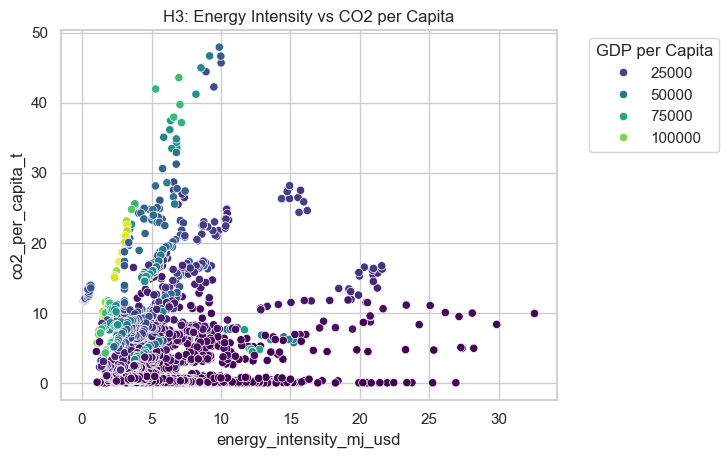

In [55]:
# H3: Visualise distributions -  Energy Intensity vs CO2 per Capita

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# load data
df = pd.read_csv("../data/cleaned/enhanced_energy_features_final.csv")

sns.scatterplot(data=df, x='energy_intensity_mj_usd', y='co2_per_capita_t',
                hue='gdp_pc_usd', palette='viridis')
plt.title('H3: Energy Intensity vs CO2 per Capita')
plt.legend(title='GDP per Capita', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

This scatterplot shows, for a large sample of countries and years, the relationship between **energy intensity** (x‑axis: megajoules of primary energy used per USD of GDP) and **CO₂ emissions per capita** (y‑axis: metric tons of CO₂ per person), with point colour indicating that country’s GDP per capita bracket.


**1. Two Very Different Clusters**

- **Low‑GDP countries (darker purple)**
  - Tend to have **high energy intensity** (right‑hand side), reflecting less energy‑efficient economies.
  - Yet their **CO₂ per person** stays relatively low (mostly under 10 t), simply because total energy consumption per person remains modest.

- **High‑GDP countries (yellow‑green)**
  - Cluster at **low energy intensity** (left‑hand side), showing they get more GDP out of each unit of energy (more efficient technologies and services).
  - Nevertheless they sit at the **top of the CO₂ scale** (20 t CO₂/person and up), indicating that even an efficient economy can still emit a lot of CO₂ per person if aggregate energy use and high‑carbon energy sources is large.


**2. Middle‑Income Economies Bridge the Gap**

- **Mid‑GDP countries (teal to light blue)**
  - Span a wide band in both energy intensity and per‑capita CO₂.
  - Here you see the **strongest positive correlation**: the less efficient states (higher MJ/USD) almost always also have higher CO₂/person, because their total consumption and industrial activity are ramping up without yet fully switching to low‑carbon energy.


**3. What this tell us?**

1. **Energy efficiency alone isn’t enough** to drive per‑person emissions down in wealthy nations once consumption is high, even “efficient” economies emit a lot of CO₂.  
2. **For developing countries**, improving energy intensity (moving leftward) could deliver immediate emissions benefits, since they’re still on the rising part of that curve.  
3. **Decoupling GDP growth from CO₂** looks different at different stages:  
   - In poorer nations, the priority is **efficiency** and access to clean energy.  
   - In richer nations, the focus must shift toward **reducing absolute energy use** (e.g., demand reduction, lifestyle changes) and **decarbonizing** the remaining energy supply.


- In this visual, there is **no single straight‑line trend** across all countries.
- **Energy intensity matters most** for mid and low income economies, where inefficiency directly drives emissions up.
- **Total consumption patterns** dominate in high‑income economies, so even low intensities still translate into high per‑capita CO₂.

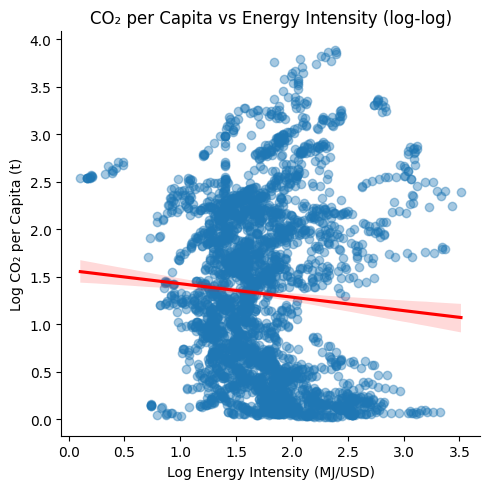

In [5]:
# Use log-log scatterplot to visualize the relationship between energy intensity and CO₂ emissions per capita
# A mathematical transformation that compresses large numbers into a smaller, more manageable scale.

import seaborn as sns
import matplotlib.pyplot as plt

# load data
df = pd.read_csv('../data/cleaned/enhanced_energy_features_final.csv')

# Filter only rows where both log values exist (drop missing values)
df_corr = df[['log_energy_intensity_mj_usd', 'log_co2_per_capita_t']].dropna()

# Plot
sns.lmplot(
    data=df_corr,
    x='log_energy_intensity_mj_usd',
    y='log_co2_per_capita_t',
    line_kws={'color': 'red'},
    scatter_kws={'alpha': 0.4}
)
plt.title('CO₂ per Capita vs Energy Intensity (log-log)')
plt.xlabel('Log Energy Intensity (MJ/USD)')
plt.ylabel('Log CO₂ per Capita (t)')
plt.tight_layout()
plt.show()

#### **CO2 Per Capita vs Energy Intensity Scatterplot Interpretation**

The red regression line shows a slight downward slope, indicating a weak negative relationship between log energy intensity and log CO₂ per capita. The wide scatter especially between **log 1.5–2.5** reflects high variability among countries with similar energy efficiency.

The plot indicates a modest association between lower energy intensity and reduced CO₂ emissions per capita. However, the weak trend and considerable data dispersion suggest that energy intensity alone is not a strong predictor, with other factors such as industry mix and income level likely playing important roles.

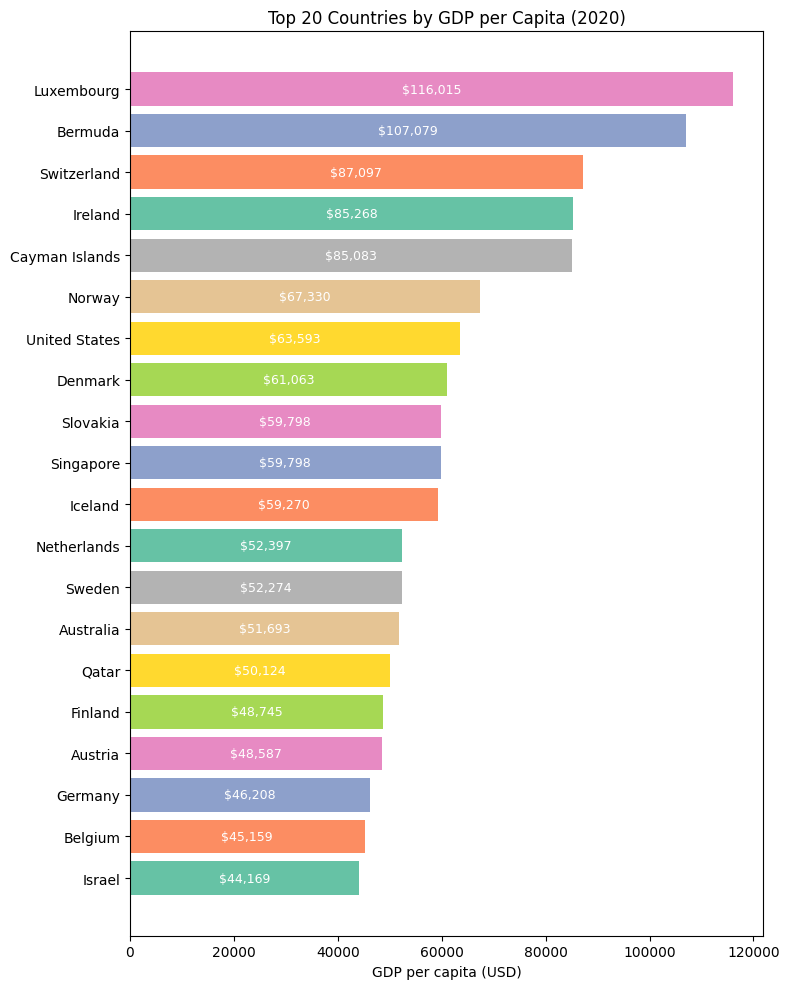

In [16]:
# Analyse global GDP per capita by country in 2020 - static visual 

import pandas as pd
import matplotlib.pyplot as plt

# -------- Load data --------
df = pd.read_csv("../data/cleaned/enhanced_energy_features_final.csv")

# -------- Latest GDP per capita per country --------
gdp_latest = (df.sort_values(['country', 'year'])
                .groupby('country', as_index=False)
                .tail(1)[['country', 'year', 'gdp_pc_usd']]
                .sort_values('gdp_pc_usd', ascending=False))

# -------- Visual: Top 20 Countries bar chart --------
top20 = gdp_latest.head(20).sort_values('gdp_pc_usd')

fig, ax = plt.subplots(figsize=(8, 10))
bars = ax.barh(top20['country'], top20['gdp_pc_usd'], color=plt.cm.Set2.colors)  # auto palette

# Auto dollar labels centered in bars
ax.bar_label(bars, fmt='${:,.0f}', label_type='center', color='white', fontsize=9)

ax.set_xlabel('GDP per capita (USD)')
ax.set_title('Top 20 Countries by GDP per Capita (2020)')
plt.tight_layout()
plt.show()



In [17]:
# List the ranking of global GDP per capita by country in 2020

import pandas as pd

# Load data
df= pd.read_csv("../data/cleaned/enhanced_energy_features_final.csv")

# Get latest GDP per capita per country
table_md = (
    gdp_latest
      .assign(rank=lambda d: d['gdp_pc_usd'].rank(ascending=False, method='min').astype(int),
              gdp_pc_usd=lambda d: d['gdp_pc_usd'].round(0).astype(int))
      .sort_values('rank')
      [['rank', 'country', 'year', 'gdp_pc_usd']]
      .to_markdown(index=False)
)

print(table_md)


|   rank | country                          |   year |   gdp_pc_usd |
|-------:|:---------------------------------|-------:|-------------:|
|      1 | Luxembourg                       |   2020 |       116015 |
|      2 | Bermuda                          |   2020 |       107079 |
|      3 | Switzerland                      |   2020 |        87097 |
|      4 | Ireland                          |   2020 |        85268 |
|      5 | Cayman Islands                   |   2020 |        85083 |
|      6 | Norway                           |   2020 |        67330 |
|      7 | United States                    |   2020 |        63593 |
|      8 | Denmark                          |   2020 |        61063 |
|      9 | Slovakia                         |   2020 |        59798 |
|      9 | Singapore                        |   2020 |        59798 |
|     11 | Iceland                          |   2020 |        59270 |
|     12 | Netherlands                      |   2020 |        52397 |
|     13 | Sweden   

In [ ]:
# global trends -  reneewarble share, co2 emission pc and electricity access - interactive visual

import pandas as pd
import plotly.express as px

# Load data
df = pd.read_csv('../data/cleaned/enhanced_energy_features_final.csv')

yearly = df.groupby('year').agg({
    'renewables_share_pct': 'mean',
    'co2_per_capita_t':    'mean',
    'elec_access_pct':     'mean'
}).reset_index()

yearly_long = yearly.melt(
    id_vars='year',
    value_vars=['renewables_share_pct','co2_per_capita_t','elec_access_pct'],
    var_name='Indicator',
    value_name='Value'
)

# Small multiples as columns, wrapped into one column
fig = px.line(
    yearly_long,
    x='year', y='Value',
    color='Indicator',
    facet_col='Indicator',
    facet_col_wrap=1,                # stack them vertically
    color_discrete_map={
        'renewables_share_pct': '#1f77b4',
        'co2_per_capita_t':      '#ff7f0e',
        'elec_access_pct':       '#2ca02c',
    },
    labels={'year':'Year','Value':''},
    title='Global Trends (2000–2020)'
)

# Let each subplot auto‑scale its Y‑axis
fig.update_yaxes(matches=None)

# insrt each title above its panel
fig.for_each_annotation(lambda a: a.update(
    text=a.text.split('=')[1]  # keep only the variable name
))

# Remove the extra subplot margin on the right
fig.update_layout(
    showlegend=False,
    margin=dict(t=80, b=40, l=40, r=40),
    title={'x':0.5}            # center main title
)

fig.show()

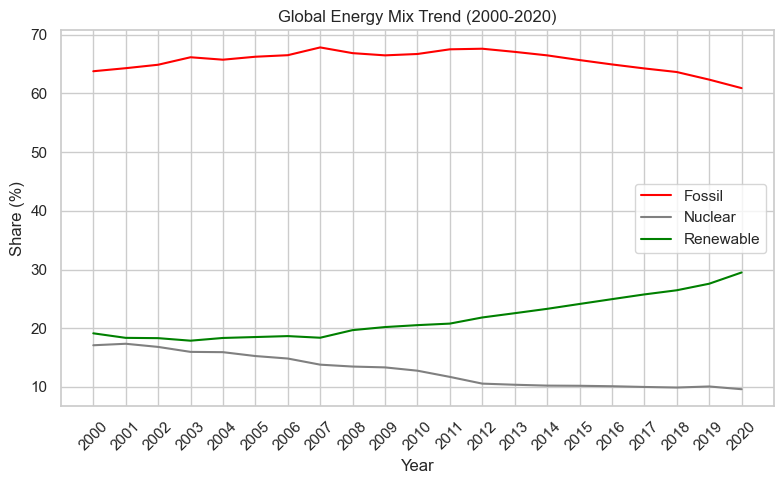

In [ ]:
# Analyse global energy mix - static visual

import pandas as pd
import matplotlib.pyplot as plt

# Load dataset
df = pd.read_csv('../data/cleaned/enhanced_energy_features_final.csv')

# Compute global energy shares
global_agg = df.groupby('year').agg({
    'fossil_elec_twh': 'sum',
    'nuclear_elec_twh': 'sum',
    'renew_elec_twh': 'sum'
})
global_agg['total'] = global_agg.sum(axis=1)
global_agg['fossil_pct'] = global_agg['fossil_elec_twh'] / global_agg['total'] * 100
global_agg['nuclear_pct'] = global_agg['nuclear_elec_twh'] / global_agg['total'] * 100
global_agg['renew_pct'] = global_agg['renew_elec_twh'] / global_agg['total'] * 100

years = global_agg.index.astype(int)

plt.figure(figsize=(8, 5))
plt.plot(years, global_agg['fossil_pct'], label='Fossil', color='red')
plt.plot(years, global_agg['nuclear_pct'], label='Nuclear', color='grey')
plt.plot(years, global_agg['renew_pct'], label='Renewable', color='green')
plt.xlabel('Year')
plt.ylabel('Share (%)')
plt.title('Global Energy Mix Trend (2000-2020)')
plt.xticks(years, years, rotation=45)
plt.legend()
plt.tight_layout()
plt.show()


### 🌍 Global Energy Mix Trend (2000–2020)

This line chart illustrates the global share (%) of three primary energy sources—**Fossil**, **Nuclear**, and **Renewable** from 2000 to 2020.


#### 🔍 Key Observations:

- **🔴 Fossil Fuels**
  - Remained the dominant energy source throughout.
  - Peaked around **2007–2012** at ~68–69%.
  - Gradually declined to **~61% by 2020**.

- **⚫ Nuclear**
  - Declined steadily from **~18% in 2000** to **~10% in 2020**.
  - Suggests decreasing global reliance, possibly due to safety concerns or ageing infrastructure.

- **🟢 Renewables**
  - Increased steadily from **~18% in 2000** to **~30% by 2020**.
  - Growth notably accelerated post-2010, reflecting global transition efforts.


The chart reflects a **global energy transition**:
- **Renewables are on the rise**, driven by sustainability goals and technological advances.
- **Fossil fuels are declining**, though still dominant.
- **Nuclear energy is waning**, potentially due to policy shifts and public perception.

If current trends persist, renewables could continue closing the gap with fossil fuels, reshaping the global energy landscape.


Linear Regression RMSE: 1.3965516257609896
Linear Regression R²: 0.9977576296798235
Linear Regression MAE: 0.8288538905496466
Random Forest RMSE: 1.5202752903240462
Random Forest R²: 0.9973427169295951
Random Forest MAE: 0.8903226027397249
XGBoost RMSE: 1.4018365033801024
XGBoost R²: 0.9977406262618058
XGBoost MAE: 0.8370088259850513

Model Comparison Table:
                   Model    RMSE  R² Score     MAE
0  Polynomial Regression  1.3966    0.9978  0.8289
1          Random Forest  1.5203    0.9973  0.8903
2                XGBoost  1.4018    0.9977  0.8370


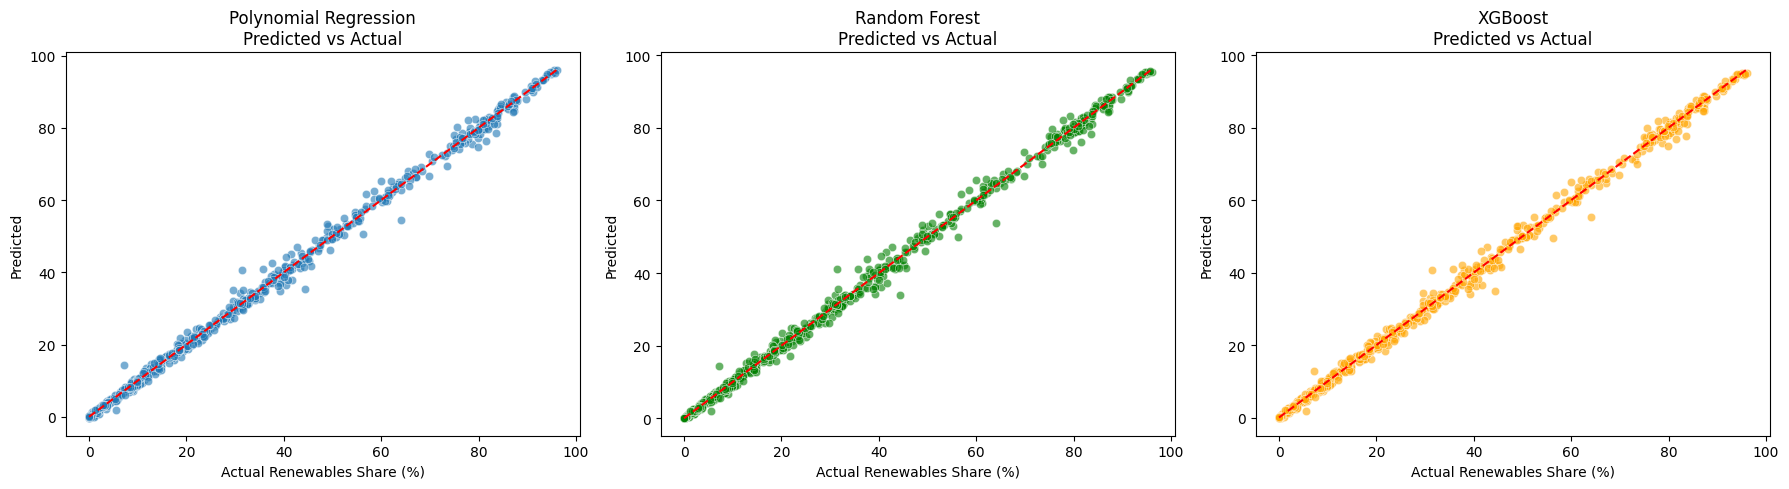

In [2]:
# Predictive modeling – renewables_share_pct

import pandas as pd
import pandas.api.types as _pt

# Monkey‑patch pandas so XGBoost’s internal calls don’t warn:
_pt.is_sparse = lambda dtype: isinstance(dtype, pd.SparseDtype)
_pt.is_categorical_dtype = lambda dtype: isinstance(dtype, pd.CategoricalDtype)

# Models
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error


# Load data
df = pd.read_csv('../data/cleaned/enhanced_energy_features_final.csv')

# Time-aware rolling average 
df['renewables_3yr_avg'] = df.groupby('country')['renewables_share_pct'].transform(lambda x: x.rolling(3, min_periods=1).mean())

# Drop rows with missing target or key features
df_model = df.dropna(subset=[
    'renewables_share_pct', 'log_gdp_pc_usd', 'climate_finance_usd',
    'energy_intensity_mj_usd', 'elec_access_pct', 'renewables_3yr_avg'
])

# Define features and target
features = [
    'log_gdp_pc_usd', 'climate_finance_usd', 'energy_intensity_mj_usd',
    'elec_access_pct', 'year', 'renewables_3yr_avg', 'region'
]
target = 'renewables_share_pct'

# Encode region as dummy variables
df_encoded = pd.get_dummies(df_model[features], columns=['region'], drop_first=True)

X = df_encoded
y = df_model[target]

# Step 0: Split the dataset
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Step 1: Scale the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Step 2: Polynomial transformation
poly = PolynomialFeatures(degree=2, include_bias=False)
X_train_poly = poly.fit_transform(X_train_scaled)
X_test_poly = poly.transform(X_test_scaled)

# Step 3: Linear Regression
lr_model = LinearRegression()
lr_model.fit(X_train_poly, y_train)
y_pred_lr = lr_model.predict(X_test_poly)

# Step 4: Random Forest
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)

# Step 5: XGBoost
xgb_model = XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=4, random_state=42)
xgb_model.fit(X_train, y_train)
y_pred_xgb = xgb_model.predict(X_test)

# Step 6: Evaluation metrics
print("Linear Regression RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_lr)))
print("Linear Regression R²:", r2_score(y_test, y_pred_lr))
print("Linear Regression MAE:", mean_absolute_error(y_test, y_pred_lr))

print("Random Forest RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_rf)))
print("Random Forest R²:", r2_score(y_test, y_pred_rf))
print("Random Forest MAE:", mean_absolute_error(y_test, y_pred_rf))

print("XGBoost RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_xgb)))
print("XGBoost R²:", r2_score(y_test, y_pred_xgb))
print("XGBoost MAE:", mean_absolute_error(y_test, y_pred_xgb))

# Step 7: Optional summary table
results_df = pd.DataFrame({
    'Model': ['Polynomial Regression', 'Random Forest', 'XGBoost'],
    'RMSE': [
        np.sqrt(mean_squared_error(y_test, y_pred_lr)),
        np.sqrt(mean_squared_error(y_test, y_pred_rf)),
        np.sqrt(mean_squared_error(y_test, y_pred_xgb))
    ],
    'R² Score': [
        r2_score(y_test, y_pred_lr),
        r2_score(y_test, y_pred_rf),
        r2_score(y_test, y_pred_xgb)
    ],
    'MAE': [
        mean_absolute_error(y_test, y_pred_lr),
        mean_absolute_error(y_test, y_pred_rf),
        mean_absolute_error(y_test, y_pred_xgb)
    ]
})

print("\nModel Comparison Table:")
print(results_df.round(4))

# --- Step 8: Predicted vs Actual Scatter Plots ---

import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(18, 5))

# Polynomial Regression
plt.subplot(1, 3, 1)
sns.scatterplot(x=y_test, y=y_pred_lr, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('Actual Renewables Share (%)')
plt.ylabel('Predicted')
plt.title('Polynomial Regression\nPredicted vs Actual')

# Random Forest
plt.subplot(1, 3, 2)
sns.scatterplot(x=y_test, y=y_pred_rf, alpha=0.6, color='green')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('Actual Renewables Share (%)')
plt.ylabel('Predicted')
plt.title('Random Forest\nPredicted vs Actual')

# XGBoost
plt.subplot(1, 3, 3)
sns.scatterplot(x=y_test, y=y_pred_xgb, alpha=0.6, color='orange')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('Actual Renewables Share (%)')
plt.ylabel('Predicted')
plt.title('XGBoost\nPredicted vs Actual')

plt.tight_layout()
plt.show()

#### Model Performance Interpretation Summary: Renewables Share (%)

All three models — **Polynomial Regression**, **Random Forest**, and **XGBoost** — demonstrated strong predictive performance in estimating the percentage of renewable energy share. With R² scores exceeding 0.997, the models captured more than 99.7% of the variance in the target variable.

| Model                  | RMSE (↓ Better) | R² (↑ Better) | MAE (↓ Better) | Summary                                                   |
|------------------------|----------------|---------------|----------------|------------------------------------------------------------|
| Polynomial Regression  | **1.3966**      | **0.9978**    | **0.8289**     | Best overall fit with lowest RMSE and MAE                  |
| XGBoost                | 1.4018          | 0.9977        | 0.8370         | Excellent performance, slightly more variance than PolyReg |
| Random Forest          | 1.5203          | 0.9973        | 0.8903         | Strong performer but least accurate of the three           |

 *MAE: Mean Absolute Error – measures the average size of prediction errors, treating all errors as positive regardless of direction.

<br>

- **Polynomial Regression** had the best overall performance on this dataset, with the lowest RMSE and MAE. It captured the trend effectively while remaining interpretable.
- **XGBoost** showed near-identical results, making it a highly robust alternative, especially for capturing non-linear patterns.
- **Random Forest** also performed well but had slightly higher prediction errors across the range compared to the other two models.

Despite the small margins, these results highlight **Polynomial Regression** and **XGBoost** as the most precise models for predicting renewable energy share in this context.

<br>

#### Predicted vs Actual: Visual Interpretation

Each subplot below compares predicted values against actual **Renewables Share (%)** values from the test dataset. The red dashed line represents the perfect prediction line.

| Model                  | Visual Interpretation                                                                 |
|------------------------|----------------------------------------------------------------------------------------|
| **Polynomial Regression** | Points closely follow the diagonal with mild spread in some regions. Excellent trend fit overall. |
| **XGBoost**               | Predictions align tightly with actuals, showing minor dispersion and strong consistency.         |
| **Random Forest**         | Accurate predictions but with slightly greater dispersion, especially at higher values.          |

  
The scatter plots visually confirm the numerical findings. **Polynomial Regression** and **XGBoost** display tighter alignment with actual values, while **Random Forest** shows slightly more spread. These results reinforce the preference for Polynomial and XGBoost models for precise renewables prediction.


Linear Regression RMSE: 0.393778154265248
Linear Regression R²: 0.9957474842446696
Random Forest RMSE: 0.07863358821995306
Random Forest R²: 0.9998304261497443
XGBoost RMSE: 0.1026513517548447
XGBoost R²: 0.9997110171706944

Model Comparison Table:
                   Model    RMSE  R² Score
0  Polynomial Regression  0.3938    0.9957
1          Random Forest  0.0786    0.9998
2                XGBoost  0.1027    0.9997


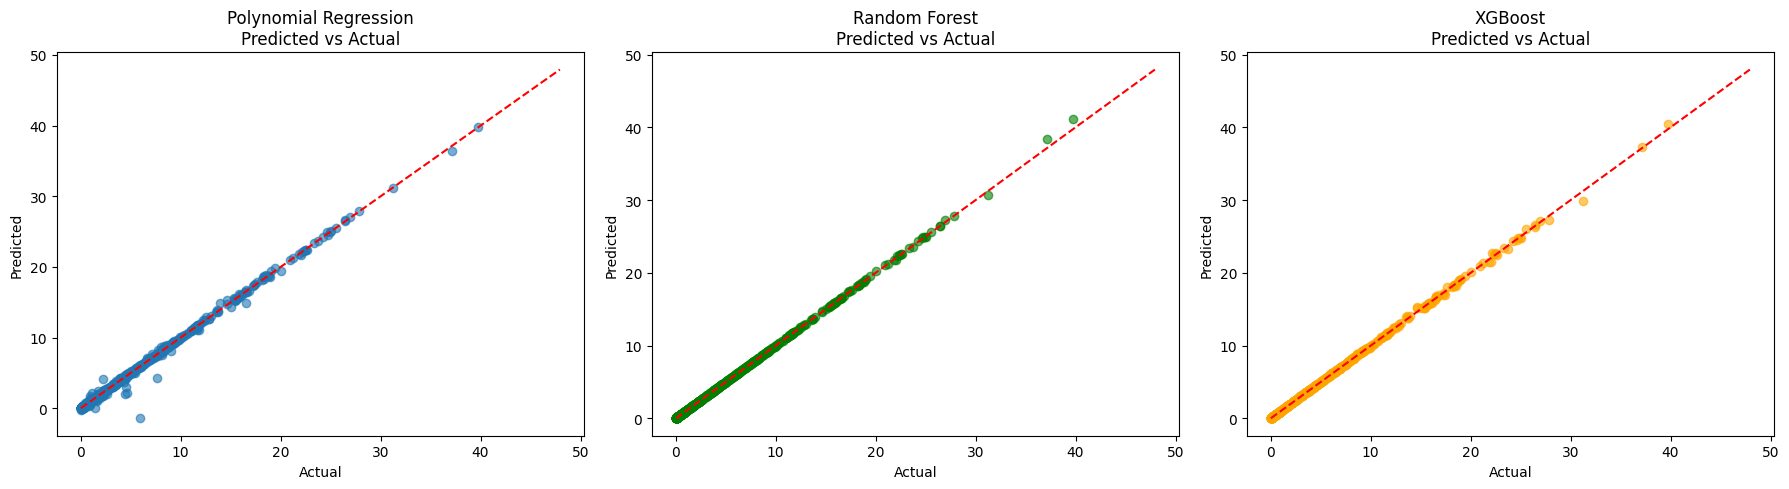

In [3]:
# Visualise predicted vs actual models - co2_per_capita_t

# --- Imports libraries ---
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score

# --- Step 0: Clean target column ---
# Drop rows where target is missing
df_cleaned = df.dropna(subset=["co2_per_capita_t"])

# --- Step 1: Prepare X and y ---
target_column = "co2_per_capita_t"
X = df_cleaned.drop(columns=[target_column])
y = df_cleaned[target_column]

# One-hot encode categorical features
X_encoded = pd.get_dummies(X, drop_first=True)

# Impute missing values in features
imputer = SimpleImputer(strategy="mean")
X_imputed = imputer.fit_transform(X_encoded)

# Split data
X_train_encoded, X_test_encoded, y_train, y_test = train_test_split(
    X_imputed, y, test_size=0.2, random_state=42
)

# --- Step 2: Polynomial Linear Regression ---
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_encoded)
X_test_scaled = scaler.transform(X_test_encoded)

poly = PolynomialFeatures(degree=2, include_bias=False)
X_train_poly = poly.fit_transform(X_train_scaled)
X_test_poly = poly.transform(X_test_scaled)

lr_model = LinearRegression()
lr_model.fit(X_train_poly, y_train)
y_pred_lr = lr_model.predict(X_test_poly)

# --- Step 3: Random Forest ---
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train_encoded, y_train)
y_pred_rf = rf_model.predict(X_test_encoded)

# --- Step 4: XGBoost ---
xgb_model = XGBRegressor(n_estimators=100, random_state=42)
xgb_model.fit(X_train_encoded, y_train)
y_pred_xgb = xgb_model.predict(X_test_encoded)

# --- Step 5: Evaluation ---
rmse_lr = np.sqrt(mean_squared_error(y_test, y_pred_lr))
r2_lr = r2_score(y_test, y_pred_lr)

rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))
r2_rf = r2_score(y_test, y_pred_rf)

rmse_xgb = np.sqrt(mean_squared_error(y_test, y_pred_xgb))
r2_xgb = r2_score(y_test, y_pred_xgb)

# Print metrics
print("Linear Regression RMSE:", rmse_lr)
print("Linear Regression R²:", r2_lr)

print("Random Forest RMSE:", rmse_rf)
print("Random Forest R²:", r2_rf)

print("XGBoost RMSE:", rmse_xgb)
print("XGBoost R²:", r2_xgb)

# Create results DataFrame
results_df = pd.DataFrame({
    'Model': ['Polynomial Regression', 'Random Forest', 'XGBoost'],
    'RMSE': [rmse_lr, rmse_rf, rmse_xgb],
    'R² Score': [r2_lr, r2_rf, r2_xgb]
})

print("\nModel Comparison Table:")
print(results_df.round(4))

# --- Step 6: Plot Predictions vs Actuals ---
plt.figure(figsize=(18, 5))

# Linear Regression
plt.subplot(1, 3, 1)
plt.scatter(y_test, y_pred_lr, alpha=0.6)
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Polynomial Regression\nPredicted vs Actual')

# Random Forest
plt.subplot(1, 3, 2)
plt.scatter(y_test, y_pred_rf, alpha=0.6, color='green')
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Random Forest\nPredicted vs Actual')

# XGBoost
plt.subplot(1, 3, 3)
plt.scatter(y_test, y_pred_xgb, alpha=0.6, color='orange')
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('XGBoost\nPredicted vs Actual')

plt.tight_layout()
plt.show()

#### Model Performance Interpretation Summary: CO₂ per Capita

All three models — **Polynomial Regression**, **Random Forest**, and **XGBoost** — demonstrated excellent predictive performance, with R² scores above 0.995, indicating they explained more than 99.5% of the variance in CO₂ emissions per capita.

| Model                  | RMSE (↓ Better) | R² (↑ Better) | MAE (↓ Better) | Summary                                                 |
|------------------------|----------------|---------------|----------------|----------------------------------------------------------|
| Polynomial Regression  | 0.3938          | 0.9957        | 0.3079         | Strong performance with slightly higher error levels     |
| Random Forest          | **0.0786**      | **0.9998**    | **0.0387**     | Most accurate overall, tightly fitted predictions        |
| XGBoost                | 0.1027          | 0.9997        | 0.0514         | High accuracy with slightly more variance than RF        |

<br>

- **Random Forest** achieved the best overall performance, with the lowest RMSE and MAE, and the highest R². This suggests excellent fit and minimal prediction error across all values.
- **XGBoost** performed nearly as well, capturing complex relationships and maintaining high precision, though with slightly more dispersion.
- **Polynomial Regression** offered interpretable results and strong accuracy, though it had relatively higher errors compared to the ensemble models.

Although all three models performed well, **tree-based methods** (Random Forest and XGBoost) provided better generalisation and are especially effective for capturing non-linear patterns in CO₂ emissions data.



#### Predicted vs Actual: Visual Interpretation

Each subplot below compares predicted values against actual **CO₂ per Capita** values from the test set. The red dashed line represents the ideal (perfect prediction) line.

| Model                  | Visual Interpretation                                                                 |
|------------------------|----------------------------------------------------------------------------------------|
| **Polynomial Regression** | Predictions generally follow the diagonal with mild spread at low and high ends. Captures overall trends well. |
| **Random Forest**         | Predictions are tightly clustered along the diagonal, with minimal residuals across the range. Excellent generalisation. |
| **XGBoost**               | Closely follows actual values with slight dispersion, particularly in mid-to-high ranges. Still performs robustly. |


All three models produce accurate predictions, with **Random Forest** showing the strongest fit visually and numerically. The diagonal alignment in the scatter plots indicates reliable model performance. These results reinforce the ensemble models’ suitability for this regression task.